Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.  

# DeepGrow 2D Inference Tutorial

Deepgrow is an AI Assisted Annotation tool designed for speeding up the annotation process by a user based interaction in the form of clicks. The deepgrow uses a guided predictive segmentation model, where the guidance is generated by the user in the form of positive or negative clicks. The positive clicks are guidance indicators towards the organ/region of interest, while the negative clicks are guidance signals for suggesting regions that should not be a part of the segmentation/annotation. An overview of this process is shown in the below figure:

<img src="../../figures/image_deepgrow_scheme.png" alt='deepgrow scheme'>

based on: Sakinis et al., Interactive segmentation of medical images through
fully convolutional neural networks. (2019) https://arxiv.org/abs/1903.08205

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"

## Setup imports

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import jit
from monai.config import print_config

import monai
from monai.apps.deepgrow.transforms import (
    AddGuidanceFromPointsd,
    AddGuidanceSignald,
    Fetch2DSliced,
    ResizeGuidanced,
    RestoreLabeld,
    SpatialCropGuidanced,
)
from monai.transforms import (
    EnsureChannelFirstd,
    Spacingd,
    LoadImaged,
    Transposed,
    NormalizeIntensityd,
    EnsureTyped,
    ToNumpyd,
    Activationsd,
    AsDiscreted,
    Resized,
)

print_config()

In [2]:
max_epochs = 1


def draw_points(guidance):
    if guidance is None:
        return
    colors = ["r+", "b+"]
    for color, points in zip(colors, guidance):
        for p in points:
            p1 = p[-1]
            p2 = p[-2]
            plt.plot(p1, p2, color, "MarkerSize", 30)


def show_image(image, label, guidance=None):
    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap="gray")

    if label is not None:
        masked = np.ma.masked_where(label == 0, label)
        plt.imshow(masked, "jet", interpolation="none", alpha=0.7)

    draw_points(guidance)
    plt.colorbar()

    if label is not None:
        plt.subplot(1, 2, 2)
        plt.title("label")
        plt.imshow(label)
        plt.colorbar()
        # draw_points(guidance)
    plt.show()


def print_data(data):
    for k in data:
        v = data[k]

        d = type(v)
        if type(v) in (int, float, bool, str, dict, tuple):
            d = v
        elif hasattr(v, "shape"):
            d = v.shape

        if k in ("image_meta_dict", "label_meta_dict"):
            for m in data[k]:
                print("{} Meta:: {} => {}".format(k, m, data[k][m]))
        else:
            print("Data key: {} = {}".format(k, d))

Pre-processing hyper-parameters and Transform compositions. Image is resampled to a 1.0x1.0 mm^2 resolution. The below snippet shows where the guidance signal is placed on the foreground (organ of interest)

In [3]:
# Download data and model

resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/_image.nii.gz"
dst = "_image.nii.gz"

if not os.path.exists(dst):
    monai.apps.download_url(resource, dst)

resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/deepgrow_2d.ts"
dst = "deepgrow_2d.ts"
if not os.path.exists(dst):
    monai.apps.download_url(resource, dst)

Downloading...
From: https://drive.google.com/uc?id=1cIlDXWx4pEFpldoIXMEe-5JeaOxzB05Z
To: /home/yuantingh/project_monai/Tutorials/deepgrow/ignite/_image.nii.gz
30.9MB [00:00, 31.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_J4qj-JRqQc9g8SGegq63Z_wq6gqgLLg
To: /home/yuantingh/project_monai/Tutorials/deepgrow/ignite/deepgrow_2d.ts
31.3MB [00:00, 63.7MB/s]


LoadImaged => image shape: (392, 392, 210), label shape: None
Guidance: [[[105, 66, 180]], []]


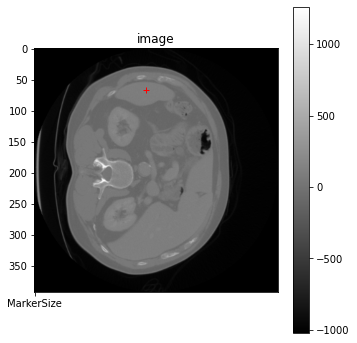

AsChannelFirstd => image shape: (210, 392, 392), label shape: None
Guidance: [[[105, 66, 180]], []]


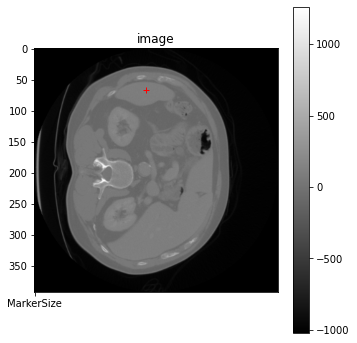

Spacingd => image shape: (210, 392, 392), label shape: None
Guidance: [[[105, 66, 180]], []]


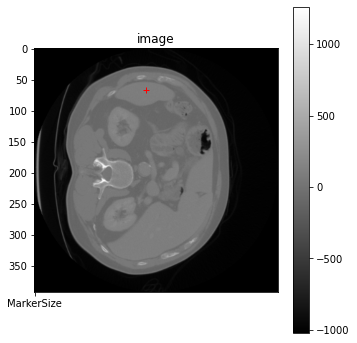

AddGuidanceFromPointsd => image shape: (210, 392, 392), label shape: None
Guidance: [[[66, 180]], [], 105]


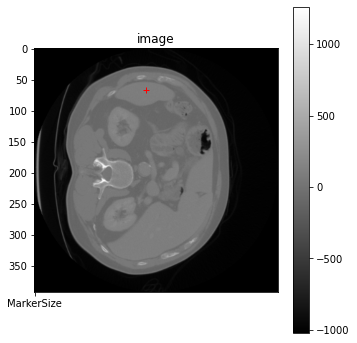

Fetch2DSliced => image shape: (392, 392), label shape: None
Guidance: [[[66, 180]], [], 105]


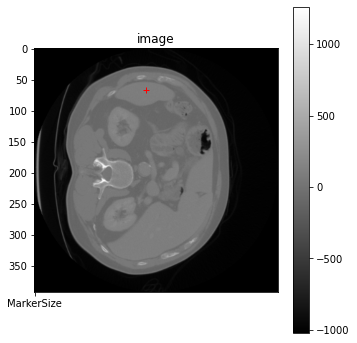

AddChanneld => image shape: (1, 392, 392), label shape: None
Guidance: [[[66, 180]], [], 105]


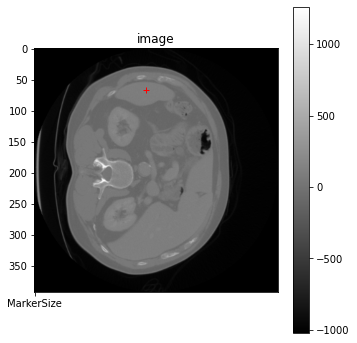

SpatialCropGuidanced => image shape: (1, 256, 256), label shape: None
Guidance: [[[66, 128]], []]


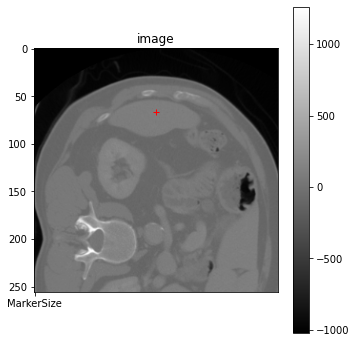

Resized => image shape: (1, 256, 256), label shape: None
Guidance: [[[66, 128]], []]


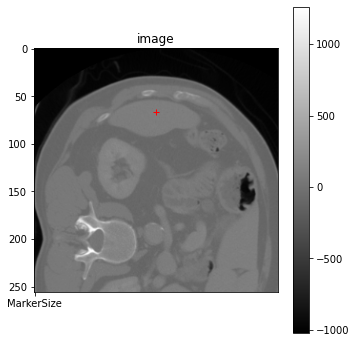

ResizeGuidanced => image shape: (1, 256, 256), label shape: None
Guidance: [[[66, 128]], []]


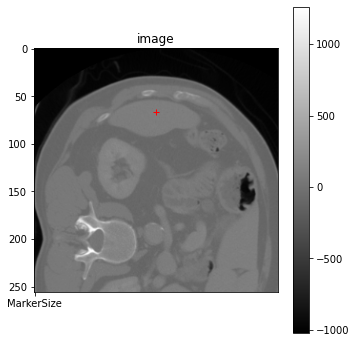

NormalizeIntensityd => image shape: (1, 256, 256), label shape: None
Guidance: [[[66, 128]], []]


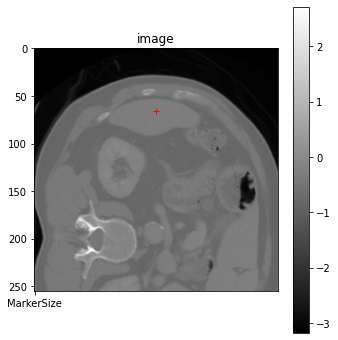

AddGuidanceSignald => image shape: (3, 256, 256), label shape: None
Guidance: [[[66, 128]], []]


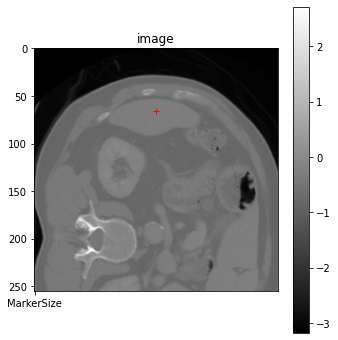

EnsureTyped => image shape: torch.Size([3, 256, 256]), label shape: None
Guidance: [[[66, 128]], []]


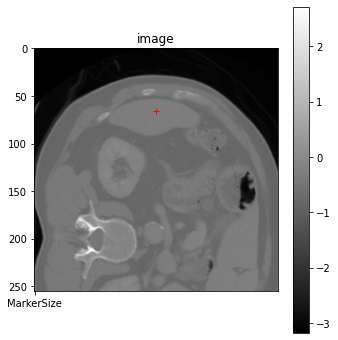

In [4]:
# Pre Processing
roi_size = [256, 256]
model_size = [128, 192, 192]
pixdim = (1.0, 1.0)
dimensions = 2

data = {"image": "_image.nii.gz", "foreground": [[66, 180, 105]], "background": []}
slice_idx = original_slice_idx = data["foreground"][0][2]

pre_transforms = [
    LoadImaged(keys="image", image_only=False),
    Transposed(keys="image", indices=[2, 0, 1]),
    Spacingd(keys="image", pixdim=pixdim, mode="bilinear"),
    AddGuidanceFromPointsd(
        ref_image="image",
        guidance="guidance",
        foreground="foreground",
        background="background",
        spatial_dims=dimensions,
    ),
    Fetch2DSliced(keys="image", guidance="guidance"),
    EnsureChannelFirstd(keys="image", channel_dim="no_channel"),
    SpatialCropGuidanced(keys="image", guidance="guidance", spatial_size=roi_size),
    Resized(keys="image", spatial_size=roi_size, mode="area"),
    ResizeGuidanced(guidance="guidance", ref_image="image"),
    NormalizeIntensityd(keys="image", subtrahend=208.0, divisor=388.0),
    AddGuidanceSignald(image="image", guidance="guidance"),
    EnsureTyped(keys="image"),
]

original_image = None
original_image_slice = None
for t in pre_transforms:
    tname = type(t).__name__

    data = t(data)
    image = data["image"]
    label = data.get("label")
    guidance = data.get("guidance")

    print(
        "{} => image shape: {}, label shape: {}".format(tname, image.shape, label.shape if label is not None else None)
    )

    image = (
        image
        if tname == "Fetch2DSliced"
        else image[:, :, slice_idx]
        if tname in ("LoadImaged")
        else image[slice_idx, :, :]
    )
    label = None

    guidance = guidance if guidance else [np.roll(data["foreground"], 1).tolist(), []]
    print("Guidance: {}".format(guidance))

    show_image(image, label, guidance)
    if tname == "Fetch2DSliced":
        slice_idx = 0
    if tname == "LoadImaged":
        original_image = data["image"]
    if tname == "EnsureChannelFirstd":
        original_image_slice = data["image"]

For a single click, the prediction is made from the deepgrow model. Corresponding input image with the known ground truth is shown along with the predicted segmentation. They has been shown for multiple slices.

Activationsd => image shape: torch.Size([3, 256, 256]), pred shape: torch.Size([1, 256, 256])
PLOT:: Activationsd => image shape: (256, 256), pred shape: (256, 256); min: 1.0725366195174502e-07, max: 1.0, sum: 2539.27978515625


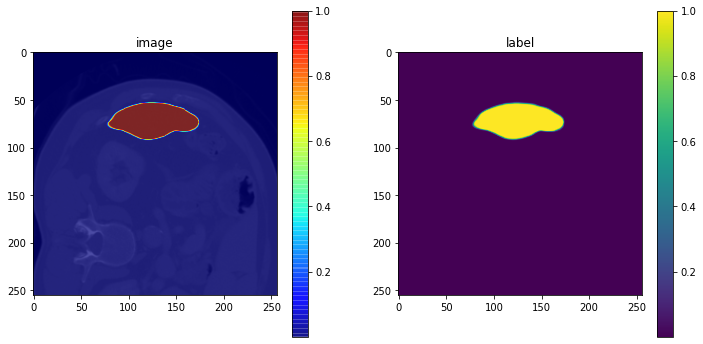

AsDiscreted => image shape: torch.Size([3, 256, 256]), pred shape: torch.Size([1, 256, 256])
PLOT:: AsDiscreted => image shape: (256, 256), pred shape: (256, 256); min: 0.0, max: 1.0, sum: 2519.0


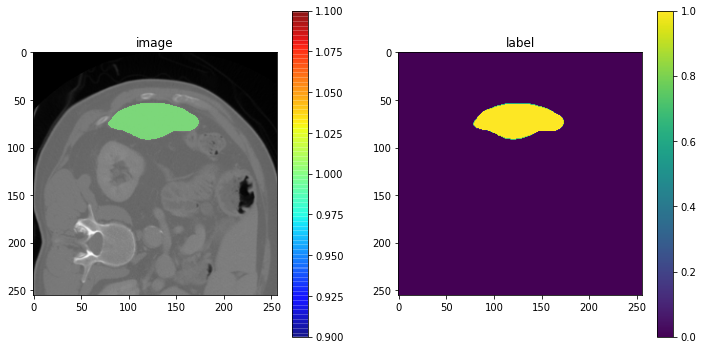

ToNumpyd => image shape: torch.Size([3, 256, 256]), pred shape: (1, 256, 256)
PLOT:: ToNumpyd => image shape: (256, 256), pred shape: (256, 256); min: 0.0, max: 1.0, sum: 2519.0


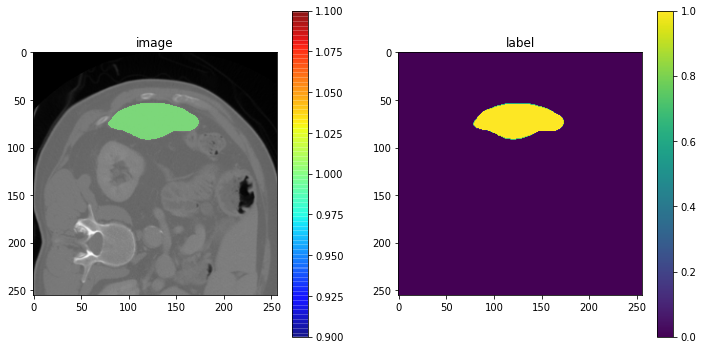

RestoreLabeld => image shape: (392, 392, 210), pred shape: (210, 392, 392)
PLOT:: RestoreLabeld => image shape: (392, 392), pred shape: (392, 392); min: 0.0, max: 1.0, sum: 2519.0


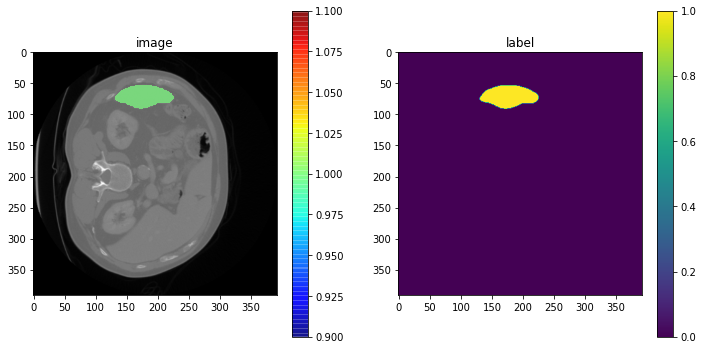

In [5]:
# Evaluation
model_path = "deepgrow_2d.ts"
model = jit.load(model_path)
model.cuda()
model.eval()

inputs = data["image"][None].cuda()
with torch.no_grad():
    outputs = model(inputs)
outputs = outputs[0]
data["pred"] = outputs

post_transforms = [
    Activationsd(keys="pred", sigmoid=True),
    AsDiscreted(keys="pred", threshold=0.5),
    ToNumpyd(keys="pred"),
    RestoreLabeld(keys="pred", ref_image="image", mode="nearest"),
]

for t in post_transforms:
    tname = type(t).__name__

    data = t(data)
    image = original_image if tname == "RestoreLabeld" else data["image"]
    label = data["pred"]
    print("{} => image shape: {}, pred shape: {}".format(tname, image.shape, label.shape))

    if tname in "RestoreLabeld":
        image = image[:, :, original_slice_idx]
        label = label[0, :, :].detach().cpu().numpy() if torch.is_tensor(label) else label[original_slice_idx]
        print(
            "PLOT:: {} => image shape: {}, pred shape: {}; min: {}, max: {}, sum: {}".format(
                tname, image.shape, label.shape, np.min(label), np.max(label), np.sum(label)
            )
        )
        show_image(image, label)
    else:
        image = image[0, :, :].detach().cpu().numpy() if torch.is_tensor(image) else image[0]
        label = label[0, :, :].detach().cpu().numpy() if torch.is_tensor(label) else label[0]
        print(
            "PLOT:: {} => image shape: {}, pred shape: {}; min: {}, max: {}, sum: {}".format(
                tname, image.shape, label.shape, np.min(label), np.max(label), np.sum(label)
            )
        )
        show_image(image, label)

In [6]:
# remove downloaded files
os.remove("_image.nii.gz")
os.remove("deepgrow_2d.ts")